# Metabolic Syndrome - Analysis of Causes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Setting options
n=800
pd.set_option('display.max_columns',n)
pd.set_option("display.max_info_rows", n)
pd.set_option('display.max_info_columns',n)
from sklearn import set_config
set_config(transform_output='pandas')

In [2]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
    
    
    
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [3]:
# Load Data
df = pd.read_csv('Data/Metabolic _Syndrome.csv')
df.head()

,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn
1,62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn
2,62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn
3,62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,No MetSyn
4,62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,No MetSyn


## Exploration

In [4]:
# Exploring Metabolic Syndrome to determine target
df['MetabolicSyndrome'].value_counts()

No MetSyn    1579
MetSyn        822
Name: MetabolicSyndrome, dtype: int64

In [5]:
# Changing labels to 0 and 1
df['MetabolicSyndrome'] = df['MetabolicSyndrome'].replace("No MetSyn", 0)
df['MetabolicSyndrome'] = df['MetabolicSyndrome'].replace("MetSyn", 1)
df['MetabolicSyndrome'] = df['MetabolicSyndrome'].astype(int)

In [6]:
df['MetabolicSyndrome'].dtype

dtype('int32')

In [7]:
# Checking Marital status
df['Marital'].value_counts()

Married      1192
Single        498
Divorced      242
Widowed       166
Separated      95
Name: Marital, dtype: int64

In [8]:
# Pulling info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 15 columns):
 #   Column             Dtype  
---  ------             -----  
 0   seqn               int64  
 1   Age                int64  
 2   Sex                object 
 3   Marital            object 
 4   Income             float64
 5   Race               object 
 6   WaistCirc          float64
 7   BMI                float64
 8   Albuminuria        int64  
 9   UrAlbCr            float64
 10  UricAcid           float64
 11  BloodGlucose       int64  
 12  HDL                int64  
 13  Triglycerides      int64  
 14  MetabolicSyndrome  int32  
dtypes: float64(5), int32(1), int64(6), object(3)
memory usage: 272.1+ KB


In [9]:
# Checking duplicates
df.duplicated().sum()

0

In [10]:
# Null check
df.isna().sum()

seqn                   0
Age                    0
Sex                    0
Marital              208
Income               117
Race                   0
WaistCirc             85
BMI                   26
Albuminuria            0
UrAlbCr                0
UricAcid               0
BloodGlucose           0
HDL                    0
Triglycerides          0
MetabolicSyndrome      0
dtype: int64

In [11]:
# Checking stats for any outliers or points of interest
df.describe()

,seqn,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
count,2401.000000,2401.000000,2284.000000,2316.000000,2375.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000
mean,67030.674302,48.691795,4005.253940,98.307254,28.702189,0.154102,43.626131,5.489046,108.247813,53.369429,128.125364,0.342357
std,2823.565114,17.632852,2954.032186,16.252634,6.662242,0.422780,258.272829,1.439358,34.820657,15.185537,95.322477,0.474597
min,62161.000000,20.000000,300.000000,56.200000,13.400000,0.000000,1.400000,1.800000,39.000000,14.000000,26.000000,0.000000
25%,64591.000000,34.000000,1600.000000,86.675000,24.000000,0.000000,4.450000,4.500000,92.000000,43.000000,75.000000,0.000000
50%,67059.000000,48.000000,2500.000000,97.000000,27.700000,0.000000,7.070000,5.400000,99.000000,51.000000,103.000000,0.000000
75%,69495.000000,63.000000,6200.000000,107.625000,32.100000,0.000000,13.690000,6.400000,110.000000,62.000000,150.000000,1.000000
max,71915.000000,80.000000,9000.000000,176.000000,68.700000,2.000000,5928.000000,11.300000,382.000000,156.000000,1562.000000,1.000000


In [12]:
# UrAlbCr and Triglycerides have huge max values.
# Checking if other Triglyceride values are similarly high
test = df.sort_values(['Triglycerides'], ascending=[False])
test['Triglycerides'].head(10)

2092    1562
1016    1311
829      979
2196     814
2076     700
1740     688
681      681
148      668
1979     666
650      626
Name: Triglycerides, dtype: int64

In [13]:
# Running test for UrAlbCr as well
test = df.sort_values(['UrAlbCr'], ascending=[False])
test['UrAlbCr'].head(10)

1557    5928.00
2070    4462.81
910     3666.67
2196    3500.00
140     3284.62
50      3267.57
246     2750.00
324     2403.85
2027    2403.85
1438    2360.66
Name: UrAlbCr, dtype: float64

### These appear to be typical values. We can safely move on.

## Exploratory Visuals

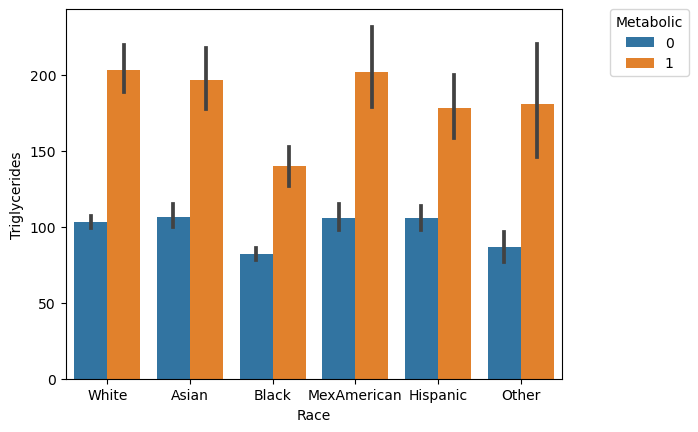

In [14]:
# Exploring data with visuals. Checking if triglycerides has correlation to target
ax = sns.barplot(data=df, x='Race', y='Triglycerides',hue='MetabolicSyndrome')
sns.move_legend(ax, "lower right", bbox_to_anchor=(1.27, .8), title='Metabolic');

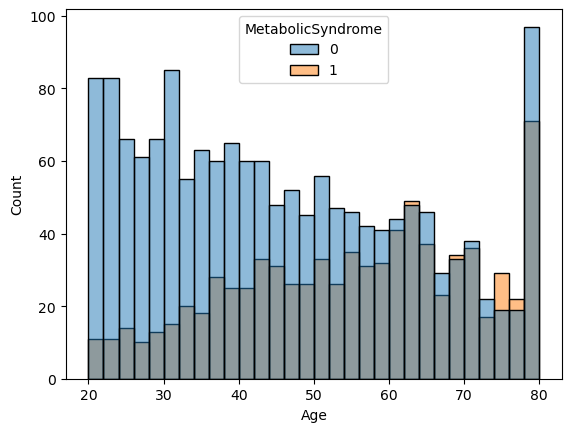

In [15]:
# Let's make a histogram of age, hueing our target
sns.histplot(data=df, x='Age', hue='MetabolicSyndrome', bins=30);

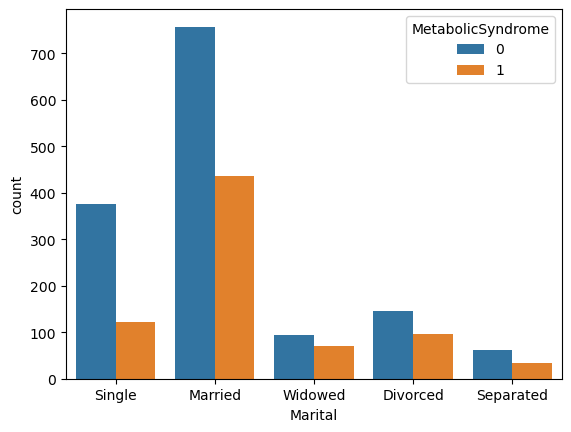

In [16]:
# Let's see if marital status plays any factor. If not we could drop it.
sns.countplot(data=df, x='Marital',hue='MetabolicSyndrome');

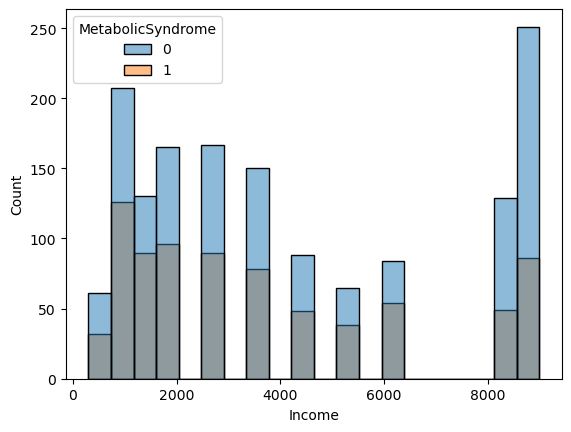

In [17]:
# Checking Income
sns.histplot(data=df,x='Income',hue='MetabolicSyndrome', bins=20);

In [18]:
# Time to define our target and choose which features to remove.
y = df['MetabolicSyndrome'].copy()
# WaistCirc and BMI seem too similar, dropping BMI since waist circumference can be a better indicator of a factor being obesity related.
# Also dropping Income and seqn
X = df.drop(columns = ['MetabolicSyndrome','BMI','Income','seqn']).copy()

In [19]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=28)

In [20]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [21]:
# Check the balance of the target. If too imbalanced, we can include SMOTE in our pipeline to even out
y.value_counts(1)

0    0.657643
1    0.342357
Name: MetabolicSyndrome, dtype: float64

In [22]:
# Save lists of column names
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)
ohe_cols = X_train.select_dtypes('object').columns
print("OneHotEncoder Columns:", ohe_cols)
# instantiate preprocessors
impute_median = SimpleImputer(strategy='median')
impute_mode = SimpleImputer(strategy='most_frequent')
scaler = StandardScaler()
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(impute_median, scaler)
ohe_pipe = make_pipeline(impute_mode, ohe_encoder)
# Making a numeric tuple for ColumnTransformer
#           (choose_a_name, pipeline_or_transformer, list_of_columns)
num_tuple = ('numeric', num_pipe, num_cols)
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)

Numeric Columns: Index(['Age', 'WaistCirc', 'Albuminuria', 'UrAlbCr', 'UricAcid',
       'BloodGlucose', 'HDL', 'Triglycerides'],
      dtype='object')
OneHotEncoder Columns: Index(['Sex', 'Marital', 'Race'], dtype='object')


In [45]:
# Create the Column Transformer
preprocessor = ColumnTransformer([num_tuple, ohe_tuple], 
                                    verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Age', 'WaistCirc', 'Albuminuria', 'UrAlbCr', 'UricAcid',
       'BloodGlucose', 'HDL', 'Triglycerides'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Sex', 'Marital', 'Race'], dtype='object'))],
                  verbose_feature_names_out=False)

In [24]:
# Fitting to training and transforming
# X_train_tf = col_transformer.fit_transform(X_train)
# X_test_tf = col_transformer.transform(X_test)
# X_train_tf.head()

,Age,WaistCirc,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,Sex_Female,Sex_Male,Marital_Divorced,Marital_Married,Marital_Separated,Marital_Single,Marital_Widowed,Race_Asian,Race_Black,Race_Hispanic,Race_MexAmerican,Race_Other,Race_White
1350,1.800453,0.157196,-0.369369,-0.176464,0.999415,0.087320,-0.345774,-0.434660,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
40,-0.133921,0.567777,-0.369369,-0.089092,0.091315,-0.294390,0.371569,0.180626,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
558,-1.271788,0.605677,-0.369369,-0.175467,0.161168,-0.411840,-1.063116,0.703620,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1709,1.174626,0.359328,-0.369369,-0.141733,0.091315,0.527756,2.914874,-0.762813,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2017,1.800453,1.654237,1.988308,-0.038673,1.767808,2.553758,-1.454394,1.195849,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [25]:
# from imblearn.over_sampling import SMOTE
# smote = SMOTE(random_state=28)
# Target imbalanced, we can use SMOTE to address
# X_train_sm, y_train_sm = smote.fit_resample(X_train_tf, y_train)
# y_train_sm.value_counts()

0    1196
1    1196
Name: MetabolicSyndrome, dtype: int64

In [46]:
# Instantiate a default random forest with a random state for reproductibility
rf = RandomForestClassifier(random_state=28)

# Fit on the training data
rf_pipe = make_pipeline(preprocessor, rf)

# Fit the model on the training data only
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'WaistCirc', 'Albuminuria', 'UrAlbCr', 'UricAcid',
       'BloodGlucose', 'HDL', 'Triglycerides'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Sex', 'Marital', 'Race'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=28))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1196
           1       1.00      1.00      1.00       604

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



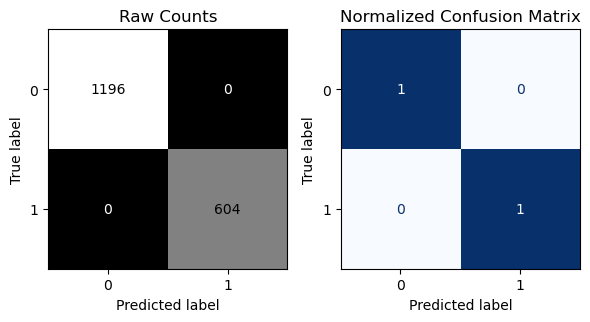


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       383
           1       0.91      0.83      0.87       218

    accuracy                           0.91       601
   macro avg       0.91      0.89      0.90       601
weighted avg       0.91      0.91      0.91       601



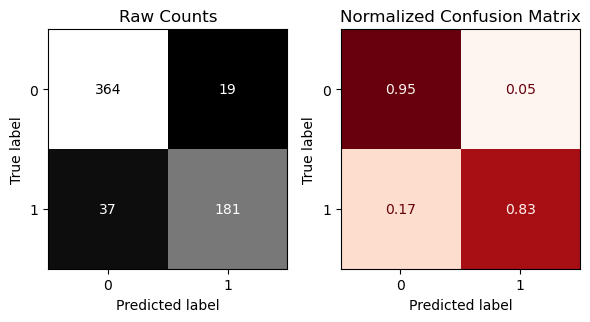

In [48]:
# Evaluate with the custom function
evaluate_classification(rf_pipe, X_train, y_train, X_test, y_test)

In [55]:
# Our training data may be overfitting. Let's try grid search to help our testing metrics.
# View parameters that could be tuned
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['Age', 'WaistCirc', 'Albuminuria', 'UrAlbCr', 'UricAcid',
          'BloodGlucose', 'HDL', 'Triglycerides'],
         dtype='object')),
                                   ('categorical',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                           

In [56]:
# Define dictionary of parameters to tune
param_grid = {'randomforestclassifier__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None],
              'randomforestclassifier__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'randomforestclassifier__min_samples_split': [2, 3, 4]}

In [57]:
from sklearn.model_selection import GridSearchCV
#Instantiate GridSearchCV
grid_search = GridSearchCV(rf_pipe, param_grid, n_jobs = -1, verbose = 1)

In [58]:
# Fit the Gridsearch on the training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 330 candidates, totalling 1650 fits


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Age', 'WaistCirc', 'Albuminuria', 'UrAlbCr', 'UricAcid',
       'BloodGlucose', 'HDL', 'Triglycerides'],
      dtype='object')),
                                                                        ('categorical',
                                                                         Pipeline(ste...
                                                                         Index(['Sex', 'Marital', 'Race'], dtype='object'))],
                                                          verbose_feature_names_out=False)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=28))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [1, 2, 3, 4, 5, 6,
                                                               7, 8, 9, 10,
                                                               None],
                         'randomforestclassifier__min_samples_leaf': [1, 2, 3,
                                                                      4, 5, 6,
                                                                      7, 8, 9,
                                                                      10],
                         'randomforestclassifier__min_samples_split': [2, 3,
                                                                       4]},
             verbose=1)

In [59]:
# Obtain the best combination directly
grid_search.best_params_

{'randomforestclassifier__max_depth': 8,
 'randomforestclassifier__min_samples_leaf': 8,
 'randomforestclassifier__min_samples_split': 2}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1196
           1       0.92      0.85      0.89       604

    accuracy                           0.93      1800
   macro avg       0.93      0.91      0.92      1800
weighted avg       0.93      0.93      0.93      1800



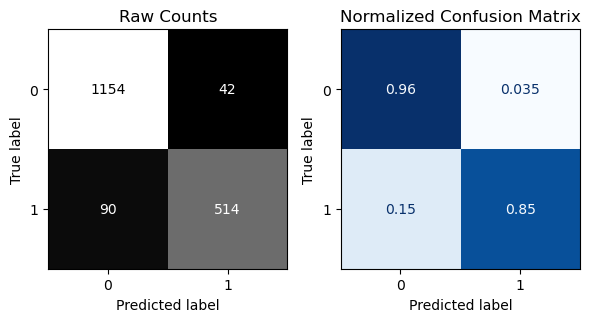


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       383
           1       0.90      0.78      0.84       218

    accuracy                           0.89       601
   macro avg       0.89      0.87      0.88       601
weighted avg       0.89      0.89      0.89       601



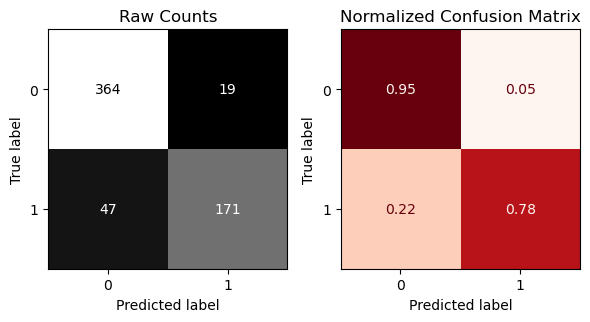

In [61]:
# Now define the best version of the model
best_model = grid_search.best_estimator_
# Predict and Evaluate with custom function
evaluate_classification(best_model, X_train, y_train, X_test, y_test)

### While our training data is less overfit, our testing data has worse recall. In some datasets this may be more tolerated but these are diagnoses for metabolic syndrome. False negatives can have fatal consequences.
### We will stick with our original rf model.

In [62]:
# From here we'll visualize our top 10 features with permutation importance
from sklearn.inspection import permutation_importance
# Permutation importance takes a fit model and the test data.
r = permutation_importance(rf_pipe, X_test, y_test, n_repeats =5, random_state = 28)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [63]:
## can make the mean importances into a series
permutation_importances = pd.Series(r['importances_mean'],index=X_test.columns,
                           name = 'permutation importance')
permutation_importances = permutation_importances.sort_values(ascending=False)
permutation_importances

BloodGlucose     0.108486
WaistCirc        0.081531
Triglycerides    0.079534
HDL              0.046589
Sex              0.024293
Age              0.017637
UricAcid         0.010649
Race             0.005657
Marital          0.002329
Albuminuria      0.001331
UrAlbCr          0.001331
Name: permutation importance, dtype: float64

In [65]:
# We can use a custom function to plot our permutation importances
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

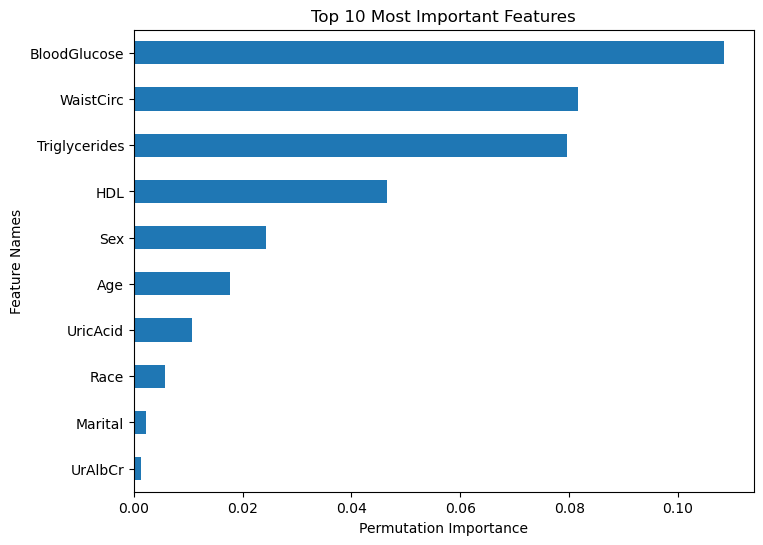

In [66]:
ax = plot_importance(permutation_importances, top_n=10)
ax.set(xlabel='Permutation Importance');

### Given the nature of the dataset (diagnosing Metabolic Syndrome) the emphasized features here make sense. However, even blood glucose levels that has the strongest relevance is only just past 0.1. An exploratory visual indicated triglycerides having an impact in predicting Metabolic Syndrome. Waist circumference also makes sense. 

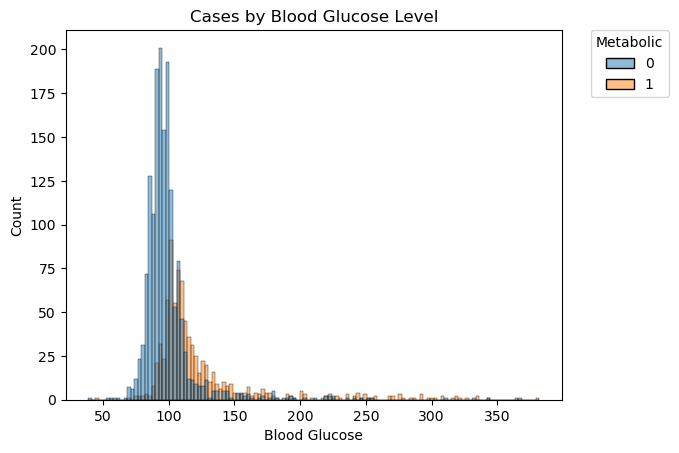

In [67]:
# Let's take a histplot of Blood Glucose
ax = sns.histplot(data=df, x='BloodGlucose', hue="MetabolicSyndrome")
ax.set(title="Cases by Blood Glucose Level", xlabel="Blood Glucose", ylabel="Count")
sns.move_legend(ax, "lower right", bbox_to_anchor=(1.23, .8), title='Metabolic');

### Here we see, even though Metabolic cases make up a third of all data points, they are well represented in higher blood glucose.

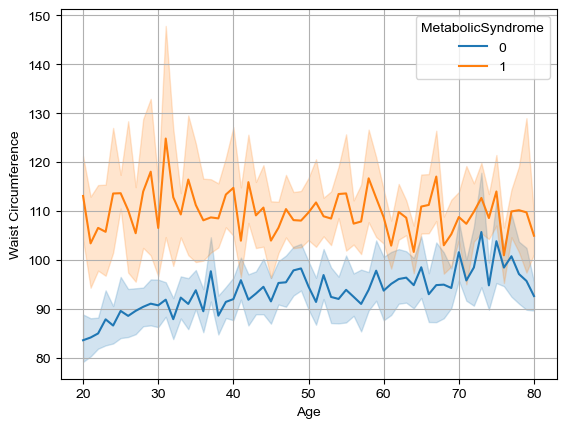

In [68]:
# Let's get a sense of waist circumference in relation to metabolic cases
g = sns.lineplot(data = df, x = "Age", y = "WaistCirc", hue = "MetabolicSyndrome")
sns.set(style="ticks")
g.set(xlabel = "Age", ylabel = "Waist Circumference")
# Setting larger figure to display by age
plt.rcParams['figure.figsize']=(12,4)
plt.grid()
plt.show();

### Metabolic cases always have a higher average waist circumference than non-cases. That said, age becomes less important a factor the older a person becomes. The spike after people enter their thirties is of some note as the highest mean rate of waist circumference. 

# KMeans Clustering

### Now that we've done some exploring under a supervised model, we will try some unsupervised clustering to see if any other insights can be gathered.

In [69]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [70]:
# Fitting to training and transforming
X_train_tf = col_transformer.fit_transform(X_train)
X_test_tf = col_transformer.transform(X_test)
X_train_tf.head()

,Age,WaistCirc,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,Sex_Female,Sex_Male,Marital_Divorced,Marital_Married,Marital_Separated,Marital_Single,Marital_Widowed,Race_Asian,Race_Black,Race_Hispanic,Race_MexAmerican,Race_Other,Race_White
1350,1.800453,0.157196,-0.369369,-0.176464,0.999415,0.087320,-0.345774,-0.434660,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
40,-0.133921,0.567777,-0.369369,-0.089092,0.091315,-0.294390,0.371569,0.180626,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
558,-1.271788,0.605677,-0.369369,-0.175467,0.161168,-0.411840,-1.063116,0.703620,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1709,1.174626,0.359328,-0.369369,-0.141733,0.091315,0.527756,2.914874,-0.762813,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2017,1.800453,1.654237,1.988308,-0.038673,1.767808,2.553758,-1.454394,1.195849,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [71]:
# We need to concatenate x and y training data to proceed
# train = pd.concat([X_train_tf, y_train], axis=1)
# train.head()

In [72]:
# Testing data
# test = pd.concat([X_test_tf, y_test], axis=1)
# test.head()

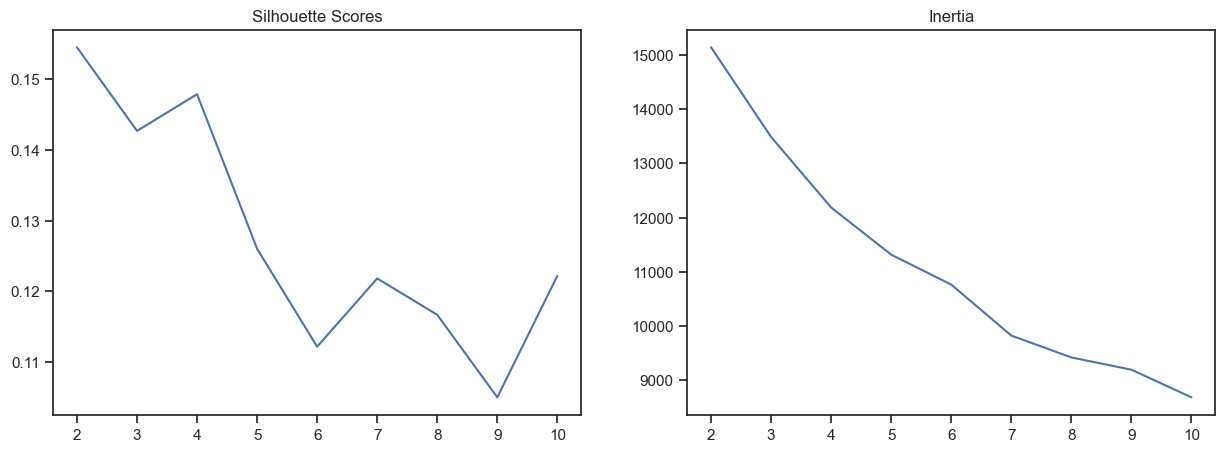

In [74]:
# Iterate over a range of k clusters to find the optimal number of clusters
ks = range(2,11)
sils = []
inertias = []
for k in ks:
  kmeans = KMeans(n_clusters=k, n_init = 'auto', random_state=28)
  kmeans.fit(X_train_tf)
  sils.append(silhouette_score(X_train_tf, kmeans.labels_))
  inertias.append(kmeans.inertia_)
#plot inertias and silhouette scores for each number of clusters.
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(ks, sils)
axes[0].set_title('Silhouette Scores')
axes[0].set_xticks(ks)
axes[1].plot(ks, inertias)
axes[1].set_title('Inertia')
axes[1].set_xticks(ks);

In [75]:
# At the fourth tick, we see a high silhouette score and a bend in inertia. Refitting KMeans with 4 clusters
kmeans = KMeans(n_clusters=4, n_init= 'auto', random_state=28)
kmeans.fit(X_train_tf)
pred_clusters = kmeans.predict(X_test_tf)
pred_clusters

array([1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 2, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 2, 0, 2, 0, 1, 2, 2, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 2, 1, 0, 1, 0, 1, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 1,
       2, 1, 1, 0, 0, 2, 1, 0, 1, 0, 0, 0, 0, 1, 1, 2, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 2, 1, 0, 2, 0, 1, 0, 0, 1, 1, 0, 1, 2, 0,
       0, 0, 0, 0, 1, 1, 2, 2, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 2, 2, 0,
       1, 2, 1, 0, 0, 2, 1, 2, 2, 0, 0, 0, 0, 1, 1, 1, 0, 2, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 2, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 2, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 2,
       1, 1, 0, 2, 0, 1, 0, 2, 2, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 2,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 2, 3, 0, 1, 2, 1, 0, 1, 2,
       1, 1, 0, 0, 1, 1, 0, 1, 2, 0, 0, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,

In [87]:
# Add the clusters as a column in the dataframe
X_train['cluster'] = kmeans.labels_
X_train.head()

,Age,Sex,Marital,Race,WaistCirc,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,cluster
1350,80,Male,Married,White,100.5,0,1.70,6.9,111,48,86,3
40,46,Male,Married,White,107.0,0,20.97,5.6,98,59,146,3
558,26,Female,Separated,Black,107.6,0,1.92,5.7,94,37,197,3
1709,69,Male,Divorced,Black,103.7,0,9.36,5.6,126,98,54,1
2017,80,Male,Divorced,White,124.2,1,32.09,8.0,195,31,245,2


In [88]:
# Now adding predicted clusters to testing data
X_test['cluster'] = pred_clusters
X_test.head(3)

,Age,Sex,Marital,Race,WaistCirc,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,cluster
905,63,Male,Widowed,White,116.8,0,5.69,4.8,106,46,108,1
1765,30,Male,NaN,White,92.0,0,2.65,5.4,92,44,63,1
1508,64,Female,Married,Hispanic,93.0,0,20.13,3.2,93,49,105,0


In [89]:
# Group the dataframe by cluster and aggregate by mean values
# Add as_index=False so that the clusters are a column, not the index
cluster_train_mean = X_train.groupby('cluster', as_index=False).mean()
cluster_train_mean

C:\Users\Rovidicus\AppData\Local\Temp\ipykernel_39328\1103666950.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_train_mean = X_train.groupby('cluster', as_index=False).mean()


,cluster,Age,WaistCirc,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides
0,0,32.641129,85.717284,0.056452,11.402278,4.381048,92.701613,57.842742,84.090726
1,1,63.019284,94.105507,0.052342,13.889697,4.965840,103.537190,68.625344,99.721763
2,2,62.615741,107.799490,1.060185,261.515741,6.122685,153.847222,47.152778,175.648148
3,3,47.511724,105.796449,0.008276,8.179034,6.271172,107.106207,44.355862,158.961379


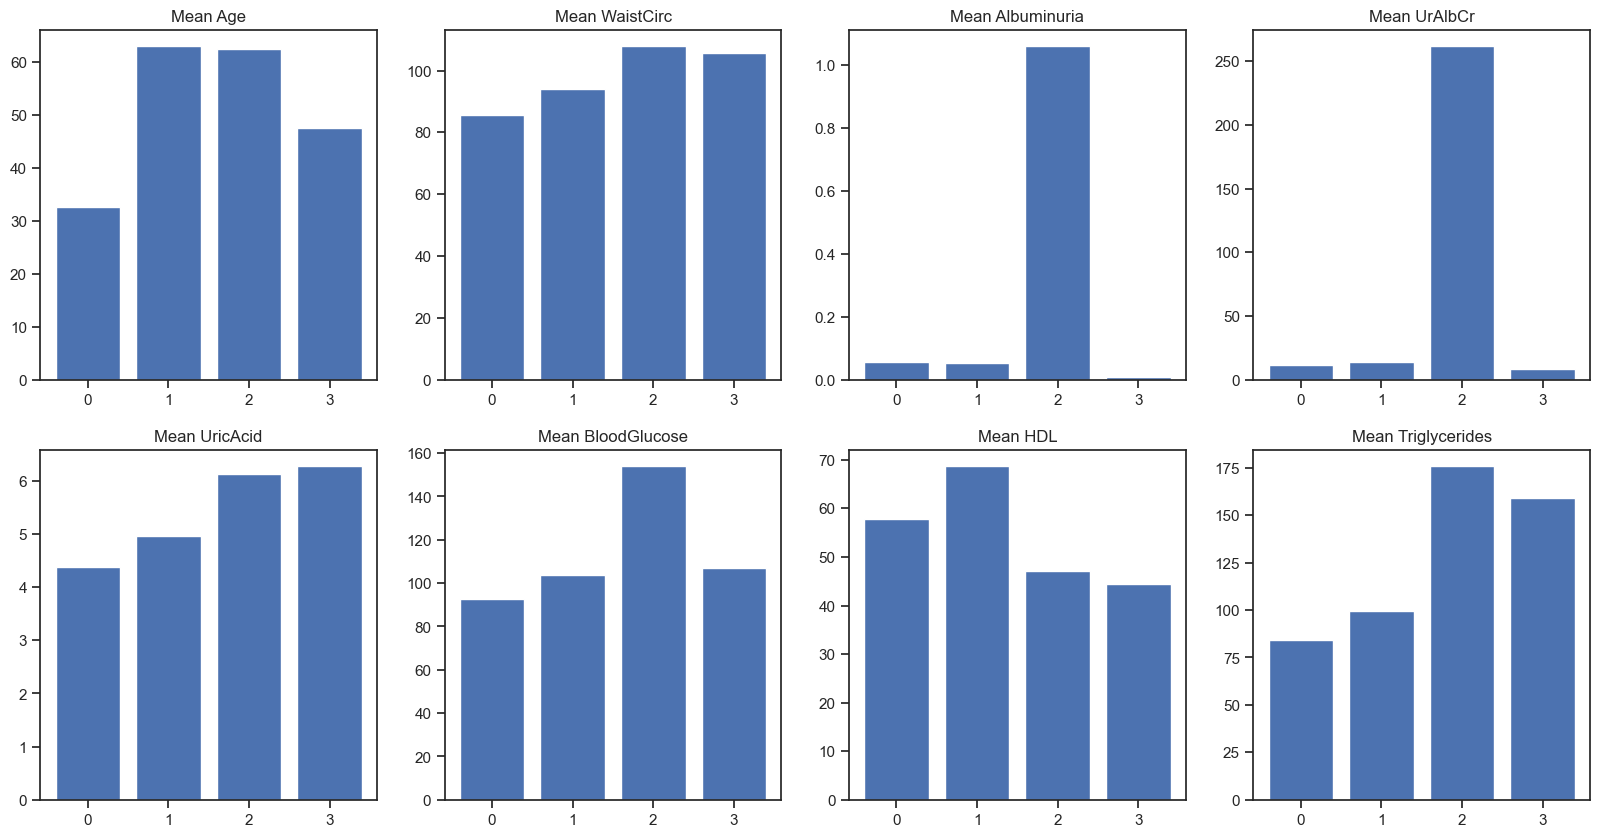

In [94]:
# Visualize means 
fig, axes = plt.subplots(2,4, figsize = (20, 10))
# fig is an array of dimensions 3,4.  axes.ravel() will flatten it to 12,1
axes = axes.ravel()
# Loop over columns and plot each in a separate figure, skip 'cluster' column
for i, col in enumerate(cluster_train_mean.columns[1:]):
  axes[i].bar(cluster_train_mean['cluster'], cluster_train_mean[col])
  axes[i].set_title(f'Mean {col}')

In [98]:
kmeans.fit(X_train_tf)
# Now we can pull our permutation importances
k = permutation_importance(kmeans, X_test_tf, y_test, n_repeats =5, random_state = 28)
k.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [99]:
## can make the mean importances into a series
permutation_importances = pd.Series(k['importances_mean'],index=X_test_tf.columns,
                           name = 'permutation importance')
permutation_importances = permutation_importances.sort_values(ascending=False)
permutation_importances

cluster              459.993349
Albuminuria          335.167868
HDL                  284.260233
UricAcid             281.403011
WaistCirc            278.153805
Age                  170.807639
BloodGlucose         158.156400
Triglycerides        153.543877
UrAlbCr              151.426115
Sex_Female            60.140951
Sex_Male              60.140951
Marital_Single        14.085565
Marital_Widowed        3.310369
Marital_Married        2.838686
Race_White             2.542133
Race_Asian             2.108739
Marital_Divorced       0.887176
Race_MexAmerican       0.604495
Race_Other            -0.000564
Marital_Separated     -0.050612
Race_Black            -0.179054
Race_Hispanic         -0.226986
Name: permutation importance, dtype: float64

### Based on our kmeans analysis, race and marital status have very minimal relevance to our data at all and should likely be dropped.

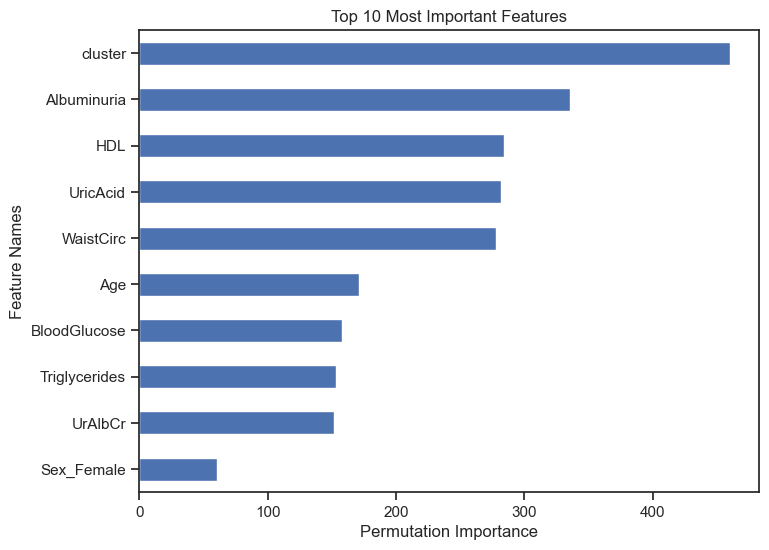

In [100]:
ax = plot_importance(permutation_importances, top_n=10)
ax.set(xlabel='Permutation Importance');

### Compared with Random Forest permutation, KMeans has very different results. Waist Circumference remains a highly relevant feature, but Uric Acid is pushed to forefront and Albuminuria is most emphasized, not even showing up on rf importance. UrAlbCr is a new feature as well, not seen on old importance chart.

In [101]:
# Fitting a random forest model on our data now
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'WaistCirc', 'Albuminuria', 'UrAlbCr', 'UricAcid',
       'BloodGlucose', 'HDL', 'Triglycerides'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Sex', 'Marital', 'Race'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=28))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1196
           1       1.00      1.00      1.00       604

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



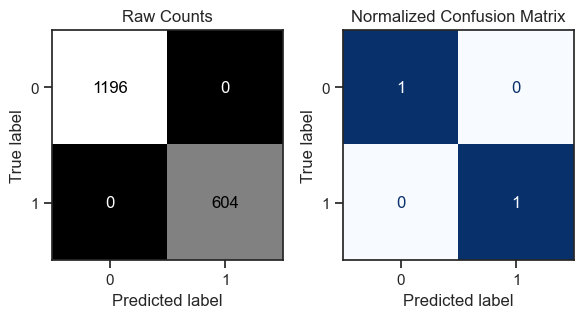


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       383
           1       0.91      0.83      0.87       218

    accuracy                           0.91       601
   macro avg       0.91      0.89      0.90       601
weighted avg       0.91      0.91      0.91       601



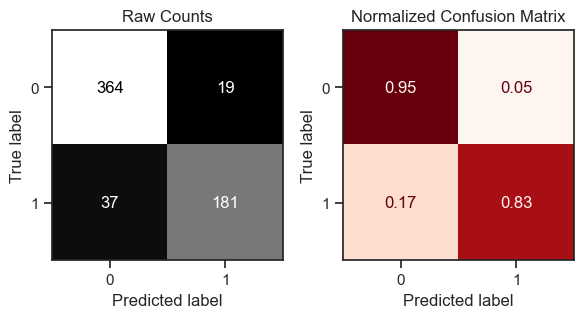

In [102]:
# Evaluate with the custom function
evaluate_classification(rf_pipe, X_train, y_train, X_test, y_test)